In [2]:
import torch as t
import days.w3d2.w3d2_tests as tests
import transformers
from einops import rearrange
import matplotlib.pyplot as plt


In [3]:

tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
example_tokens =t.LongTensor([[50257]+ tokenizer("So far, we've developed a theoretical model for understanding two-layer attention-only models. We have an overall equation describing the logits (the OV circuit), and then an equation describing how each attention head's attention pattern is computed (the QK circuit). But how do we understand them in practice? In this section, we'll reverse engineer a single two-layer model.")["input_ids"]])
print(example_tokens)



tensor([[50257,  2396,  1290,    11,   356,  1053,  4166,   257, 16200,  2746,
           329,  4547,   734,    12, 29289,  3241,    12,  8807,  4981,    13,
           775,   423,   281,  4045, 16022, 12059,   262,  2604,   896,   357,
          1169,   440,    53, 10349,   828,   290,   788,   281, 16022, 12059,
           703,  1123,  3241,  1182,   338,  3241,  3912,   318, 29231,   357,
          1169,  1195,    42, 10349,   737,   887,   703,   466,   356,  1833,
           606,   287,  3357,    30,   554,   428,  2665,    11,   356,  1183,
          9575, 11949,   257,  2060,   734,    12, 29289,  2746,    13]])


In [4]:
minigpt = tests.get_minigpt()
print(minigpt)

MiniGPT(
  (token_embedding): Embedding(50259, 256)
  (pos_embedding): Embedding(512, 256)
  (blocks): Sequential(
    (0): UniAttention(
      (project_qkv): Linear(in_features=256, out_features=768, bias=False)
      (project_output): Linear(in_features=256, out_features=256, bias=False)
    )
    (1): UniAttention(
      (project_qkv): Linear(in_features=256, out_features=768, bias=False)
      (project_output): Linear(in_features=256, out_features=256, bias=False)
    )
  )
)


In [5]:
pos_embeds = minigpt.pos_embedding.weight
tok_embeds = minigpt.token_embedding.weight
print("eshape", pos_embeds.shape)

[tokenizer.decode([x]) for x in example_tokens[0][1:]]
print(minigpt.blocks[0].project_qkv.weight.shape)
p_q,p_k,p_v = rearrange(minigpt.blocks[0].project_qkv.weight, "(t h c) ic -> t h ic c",h=8,t=3)



eshape torch.Size([512, 256])
torch.Size([768, 256])


In [15]:
pos_qs = t.einsum("pe,hea->hpa", pos_embeds,p_q )
pos_ks = t.einsum("pe,hea->hpa", pos_embeds,p_k )
tok_qs = t.einsum("pe,hea->hpa", tok_embeds,p_q )
tok_ks = t.einsum("pe,hea->hpa", tok_embeds,p_k )

pos_to_pos = t.einsum("hfa,hta->hft",pos_qs,pos_ks )
pos_to_tok = t.einsum("hfa,hta->hft",pos_qs,tok_ks )
tok_to_pos = t.einsum("hfa,hta->hft",tok_qs,pos_ks )
tok_to_tok = t.einsum("hfa,hta->hft",tok_qs,tok_ks )


In [17]:
print(pos_to_pos.var(),pos_to_tok.var(),tok_to_pos.var(),tok_to_tok.var())

tensor(503.3793, grad_fn=<VarBackward0>) tensor(25.8140, grad_fn=<VarBackward0>) tensor(65.6361, grad_fn=<VarBackward0>) tensor(71.5687, grad_fn=<VarBackward0>)


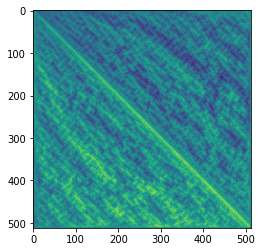

In [13]:
plt.imshow(pos_to_pos[0].detach())

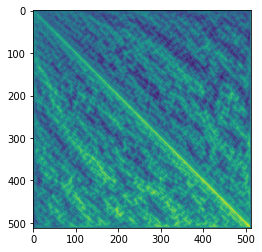

In [14]:
plt.imshow(pos_to_pos[1].detach())